# Tests de hipótesis y validación estadística

## Carga de librerías necesarias

In [3]:
import pandas as pd
import numpy as np

## Ingesta de datos

In [14]:
# Base de datos original
df_raw = pd.read_csv("https://raw.githubusercontent.com/catalinatrevisan/tp-final-analitica/refs/heads/main/data/raw/online_gaming_behavior_dataset.csv")

In [4]:
# Base de datos preprocesada
df = pd.read_csv('/content/drive/MyDrive/Analítica Descriptiva/Trabajo Final/notebooks/online_gaming_behavior_preprocessed.csv')

## Tests

#### H1 (principal): Los hábitos de uso de los jugadores (frecuencia de sesiones, duración promedio y logros desbloqueados) son los factores que más influyen en el nivel de engagement en videojuegos online.

**H0: La duración promedio de sesión no se asocia con el nivel de engagement.**

**H1: A mayor duración promedio de sesión, mayor nivel de engagement.**

In [5]:
# limpiar y normalizar la etiqueta de engagement
df['EngagementLevel_clean'] = (
    df['EngagementLevel']
    .astype(str).str.strip().str.title()   # 'low' -> 'Low', etc.
)

# mapping correcto (orden ordinal)
mapping_en = {'Low': 0, 'Medium': 1, 'High': 2}
df['EngagementLevel_num'] = df['EngagementLevel_clean'].map(mapping_en)

# chequeo rápido
print(df['EngagementLevel_clean'].unique())
print(df['EngagementLevel_num'].unique())

['Medium' 'High' 'Low']
[1 2 0]


In [6]:
from scipy.stats import spearmanr, kendalltau
import numpy as np

mask = df[['AvgSessionDurationMinutes','EngagementLevel_num']].notna().all(axis=1)
x = df.loc[mask, 'AvgSessionDurationMinutes'].astype(float)
y = df.loc[mask, 'EngagementLevel_num'].astype(int)

# Spearman
s_stat, s_p = spearmanr(x, y)
print("Spearman rho:", s_stat, "p-value:", s_p)

Spearman rho: 0.47638398131441473 p-value: 0.0


Text(0.5, 0, 'EngagementLevel')

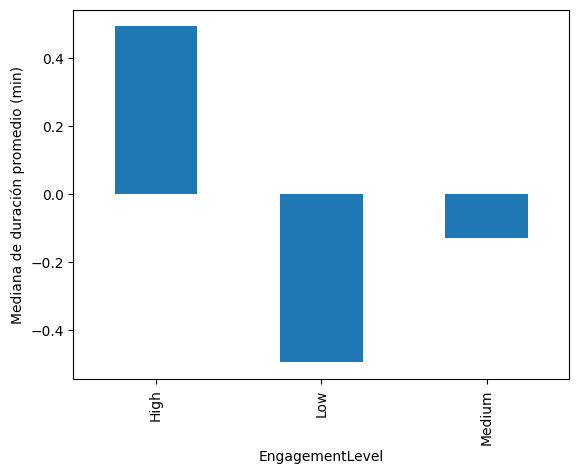

In [7]:
ax = df.loc[mask].groupby('EngagementLevel_clean')['AvgSessionDurationMinutes'].median().plot(kind='bar')
ax.set_ylabel('Mediana de duración promedio (min)')
ax.set_xlabel('EngagementLevel')

Se evaluó la hipótesis que establece que a mayor duración promedio de sesión, mayor nivel de engagement.

Para ello se aplicó el coeficiente de correlación de Spearman, dado que se trata de una relación entre una variable numérica continua (AvgSessionDurationMinutes) y una variable ordinal (EngagementLevel), previamente codificada en escala 0-1-2 (Low–Medium–High).

Resultados:

* Spearman rho = 0.4768

* p-value = 0.0000

Interpretación:

* Dado que p < 0.05, se rechaza la hipótesis nula. Se concluye que existe una asociación positiva y estadísticamente significativa entre la duración promedio de las sesiones y el nivel de engagement. Jugadores con sesiones más largas tienden a presentar mayor engagement.

**H0: La frecuencia de sesiones semanales no se asocia con el engagement.**

**H1: A mayor frecuencia de sesiones, mayor nivel de engagement.**

Para este contraste utilizamos el test Kruskal–Wallis, ya que esta prueba no paramétrica permite comparar si la distribución (mediana) de una variable numérica continúa difiere entre tres o más grupos independientes.
En nuestro caso, la variable SessionsPerWeek es numérica y los jugadores se dividen en 3 niveles de engagement (Low, Medium, High).

Este test es apropiado porque:

* no exige normalidad en los datos (a diferencia de ANOVA),

* EngagementLevel es una variable categórica ordinal con 3 categorías,

* y nos interesa comparar si la frecuencia de sesiones por semana difiere según el nivel de engagement.

En síntesis, Kruskal–Wallis evalúa si al menos uno de los grupos presenta una mediana significativamente diferente, lo cual es coherente con la hipótesis planteada.

In [8]:
from scipy.stats import kruskal

g_low    = df[df['EngagementLevel_clean']=='Low']['SessionsPerWeek']
g_med    = df[df['EngagementLevel_clean']=='Medium']['SessionsPerWeek']
g_high   = df[df['EngagementLevel_clean']=='High']['SessionsPerWeek']

stat2, p2 = kruskal(g_low, g_med, g_high)

print("Kruskal-Wallis H:", stat2)
print("p-value:", p2)

Kruskal-Wallis H: 14742.086131480732
p-value: 0.0


Se evaluó si la frecuencia de sesiones semanales se diferencia entre los distintos niveles de engagement.
Dado que EngagementLevel presenta 3 categorías independientes (Low, Medium y High), y la variable SessionsPerWeek es numérica y no se asume normalidad, se utilizó el test no paramétrico Kruskal–Wallis.

Resultados:

* * Estadístico H = 14742.0861

p-value = 0.0000

Interpretación:
* Dado que p < 0.05, se rechaza la hipótesis nula.
Existe evidencia estadística de que la frecuencia de sesiones semanales difiere significativamente entre los niveles de engagement.
En otras palabras: los jugadores con mayor engagement tienen más sesiones por semana.

#### H2 (alternativa): Las características del juego (género y nivel de dificultad) tienen un impacto significativo en la retención de jugadores, independientemente de sus hábitos de uso.

**H0: La distribución del engagement es igual en todos los géneros de juego.**

**H1: Existen diferencias en el engagement entre géneros de juego.**

Para evaluar si existe una relación entre el género del juego (GameGenre) y el nivel de engagement, se utilizó el test de Chi-Cuadrado de Independencia, ya que ambas variables son categóricas y la prueba permite contrastar si la distribución de EngagementLevel difiere significativamente entre distintos géneros. Se construyó una tabla de contingencia y se aplicó la función chi2_contingency. Si p < 0.05 se rechaza H0, concluyendo que existe relación entre las variables.

In [15]:
import pandas as pd
from scipy.stats import chi2_contingency

# tabla de contingencia
tabla = pd.crosstab(df_raw['GameGenre'], df['EngagementLevel_clean'])

chi2, p, dof, expected = chi2_contingency(tabla)

print("Chi2:", chi2)
print("p-value:", p)
print("grados de libertad:", dof)
print("\nFrecuencias esperadas:")
print(pd.DataFrame(expected, index=tabla.index, columns=tabla.columns))

Chi2: 8.611218189112536
p-value: 0.3761462722846438
grados de libertad: 8

Frecuencias esperadas:
EngagementLevel_clean         High          Low       Medium
GameGenre                                                   
Action                 2075.513414  2073.103762  3890.382825
RPG                    2053.051706  2050.668132  3848.280162
Simulation             2061.055303  2058.662437  3863.282260
Sports                 2077.837039  2075.424689  3894.738272
Strategy               2068.542539  2066.140980  3877.316481


Dado que el p-value es mayor que 0.05, no se rechaza la hipótesis nula. Por lo tanto, no se observa asociación estadísticamente significativa entre el género del juego y el nivel de engagement. En otras palabras: los distintos géneros de juego presentan niveles de engagement similares.

**H0: No hay diferencias en engagement según dificultad del juego.**

**H1: El engagement varía según el nivel de dificultad.**

Dado que ambas variables son ordinales y no se asumen distribuciones normales, se aplicó el test no paramétrico Kruskal–Wallis, que permite comparar si las medianas de EngagementLevel_num difieren estadísticamente entre los grupos Easy, Medium y Hard.

In [12]:
from scipy.stats import kruskal

d_easy   = df[df['GameDifficulty']=='Easy']['EngagementLevel_num']
d_med    = df[df['GameDifficulty']=='Medium']['EngagementLevel_num']
d_hard   = df[df['GameDifficulty']=='Hard']['EngagementLevel_num']

stat5, p5 = kruskal(d_easy, d_med, d_hard)

print("Kruskal-Wallis H:", stat5)
print("p-value:", p5)

Kruskal-Wallis H: 1.2400490652680212
p-value: 0.5379312405625488


Dado que p-value > 0.05, no se rechaza la hipótesis nula. Por lo tanto, no se observan diferencias estadísticamente significativas en el engagement en función del nivel de dificultad del juego. Esto indica que la dificultad, al menos en este dataset, no parece ser un factor determinante en el engagement.

#### H3 (alternativa): Los jugadores que realizan InGamePurchases presentan mayores niveles de engagement y retención que aquellos que no realizan compras.

**H0: Los jugadores que compran y los que no compran tienen el mismo engagement.**

**H1: Los jugadores que compran tienen mayor engagement que quienes no compran.**

Se utilizó Mann–Whitney U ya que compara diferencias en la distribución de una variable ordinal entre dos grupos independientes sin asumir normalidad.

In [13]:
from scipy.stats import mannwhitneyu

g0 = df[df['InGamePurchases_True']==False]['EngagementLevel_num']
g1 = df[df['InGamePurchases_True']==True]['EngagementLevel_num']

u_stat, p_val = mannwhitneyu(g0, g1, alternative='two-sided')

print("Mann-Whitney U:", u_stat)
print("p-value:", p_val)

Mann-Whitney U: 127222945.5
p-value: 0.10045961598055911


Dado que el p-value es mayor a 0.05, no se rechaza la hipótesis nula.
Por lo tanto, no se observa una diferencia estadísticamente significativa en el nivel de engagement entre jugadores que realizan compras y los que no realizan compras.
En este conjunto de datos, comprar dentro del juego no parece estar asociado con un mayor nivel de engagement.